# Study-01-AugmentedDataset
Details: [Notion Link](https://www.notion.so/AntWorld-Dataset-ce7a7c36f5154ed4a15e192bda2a06af)

In [2]:
import itertools
import copy
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as P
import gym
from gym import spaces
from tqdm import tqdm
import seaborn as sns

import torch
import pyRC.datasets.nordland as Nordland
import pyRC.learn.utils       as utL
from pyRC.network import ESN_NA as ESN
import pyRC.analyse.utils as utA
from pyRC.environments import AntWorld

# Plotting settings
sns.set_context("notebook", font_scale = 1.5)
sns.set_style("dark")
sns.set_palette("deep", 12)
from ipywidgets import interact, interactive, fixed, interact_manual
cmap='turbo'

## Load Environment

In [3]:
# Ant environment
env = AntWorld('AntWorld-Gym-02')

/home/anil/.virtualenv/pyRC2-vEnv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Prepare environment for training

In [4]:
# Img = np.load('AntWorld-Gym-01.npz')['Img'] # Generic Environment
Img = env.Img
print(Img.shape)
height, width = Img.shape[1:]

(8000, 10, 36)


In [5]:
device = 'cuda'

In [32]:
Imgs, Lbls = [], []
for x in np.arange(0, 2, 0.05): # Label: 1
    Imgs.append(env.getImage([x,0],0))
    Lbls.append(1) 
for x in np.arange(2, 4, 0.05): # Label: 0
    Imgs.append(env.getImage([x,0],0))
    Lbls.append(0)

nImg  = len(Imgs)
Image = torch.Tensor(Imgs).unsqueeze(1).to(device)
Label = torch.Tensor(Lbls).unsqueeze(1).to(device)
# should be of size [1, h, w]

TypeError: new() received an invalid combination of arguments - got (list, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


## Train and Test

In [14]:
def Train(config):
    NET = ESN(config)
    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(NET.parameters(), lr = config['learningRate'])
    for epoch in range(config['nEpoch']):
        Loss = 0  
        NET.reset()
        for i in range(nImg):
            optimizer.zero_grad()
            x, y = Image[i], Label[i]
            # Forward pass
            yhat = torch.sigmoid(NET(x))[0]
            loss = criterion(yhat, y)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            Loss += float(loss.item()/nImg)
        print ('Epoch [{}/{}], train_loss: {:.4f}'.format(epoch+1, config['nEpoch'], Loss))
    return NET

In [12]:
def Test(NET, IMG):
    NET.eval()
    nImg = len(IMG)
    with torch.no_grad():
        States = torch.zeros((nImg, NET.nReservoir))
        Output = torch.zeros((nImg))
        NET.reset()
        for i, im in enumerate(tqdm(IMG)):
            Output[i] = torch.sigmoid(NET(im)[0])
            States[i] = NET.leaky_IF.states[-1]
    Output = Output.detach().cpu().numpy()
    States = States.detach().cpu().numpy()
    return Output, States

In [15]:
config = utL.getConfig('config.yaml')
config = {**config['hyperparameters'], **config['experimentParameters'], **config['modelParameters'], **config['experimentDetails']}
config['nInput']     = height * width
config['nOutput']    = 1
config['nReservoir'] = 100
### Hyperparameters
config['alpha']  = 0.30
config['phi'] = 1
config['nEpoch'] = 10
config['learningRate'] = 0.01

In [28]:
y.dtype

torch.float32

In [35]:
NET = ESN(config)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(NET.parameters(), lr = config['learningRate'])
NET.reset()
for i in range(nImg):
    optimizer.zero_grad()
    x, y = Image[i], Label[i]
    # Forward pass
    yhat = torch.sigmoid(NET(x))
    loss = criterion(yhat, y)
    # Backward and optimize
    loss.backward()
    optimizer.step()

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [16]:
RC = Train(config)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [15]:
out , sta   = Test(RC, Image)
outT, staT = Test(RC, ImageT)

100%|██████████| 40/40 [00:00<00:00, 4299.09it/s]


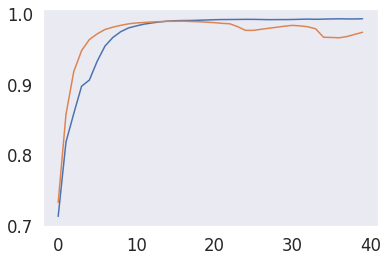

In [16]:
P.plot(out);
P.plot(outT);

In [17]:
@interact(image=(1,nImg-1,1))
def plot_I(image=1):
#     fig, ax = P.subplots(2,3, figsize=(20,4))
    axd = P.figure(figsize=(22,6), constrained_layout=True).subplot_mosaic(
    """
    1357
    2468
    """)
    axd['1'].imshow(Image[image][0].detach().cpu(),cmap=cmap)
    axd['2'].imshow(ImageT[image][0].detach().cpu(),cmap=cmap)
    axd['3'].plot(sta[:image])
    axd['4'].plot(staT[:image])
    axd['5'].hist(out[:image])
    axd['6'].hist(outT[:image])
    axd['7'].hist(sta[image])
    axd['8'].hist(staT[image])
    P.suptitle('Diff of images: {:.2f}. Outputs: {:.2f} & {:.2f}'.format(DiffT[image,image], out[image], outT[image]))

interactive(children=(IntSlider(value=1, description='image', max=39, min=1), Output()), _dom_classes=('widget…

In [18]:
STOP

NameError: name 'STOP' is not defined

## States comparison

In [ ]:
# State difference of one "trained" image and the all trained states
DiffS = np.zeros((nImg))
for i in range(nImg):
    DiffS[i]  = LA.norm(sta-sta[i], axis=1).mean()
P.plot(DiffS);

In [ ]:
# State difference of one "test" image and the all trained states
DiffST = np.zeros((nImg))
for i in range(nImg):
    DiffST[i]  = LA.norm(sta-staT[i], axis=1).mean()
P.plot(DiffST);

# Attractor States & Output analysis

# TODO calculate attractor states and concatenate them for classification

In [50]:
config['readoutType'] = 'nRes+nInput'

In [51]:
RC = ESN(config)

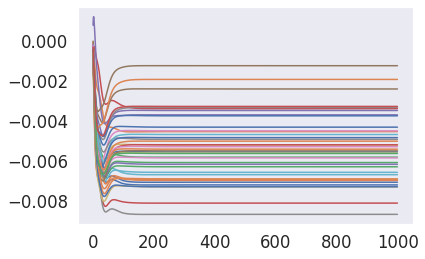

In [102]:
res = torch.zeros((40, 1000))
for i in range(40):
    RC.reset()
    for j in range(1000):
        res[i,j] = RC(Image[i])[0]
P.plot(res.T.detach().numpy());

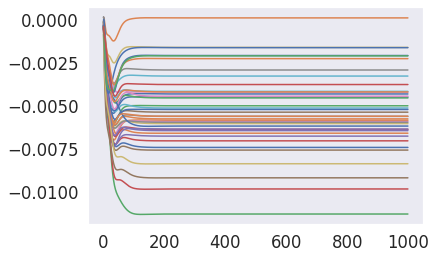

In [90]:
resT = torch.zeros((40, 1000))
for i in range(40):
    RC.reset()
    for j in range(1000):
        resT[i,j] = RC(ImageT[i])[0]
P.plot(resT.T.detach().numpy());

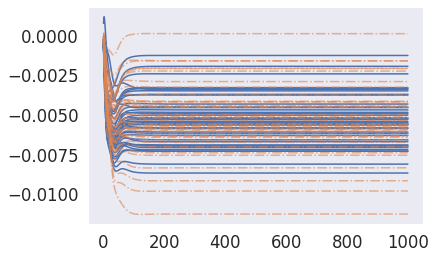

In [103]:
P.plot(res.T.detach().numpy(),c='C0')
P.plot(resT.T.detach().numpy(), c='C1', linestyle='-.', alpha=0.6);

# Notes
No training so far, but, the neuron activities and output seem too similar to each other

In [ ]:
axd = P.figure(figsize=(22,6), constrained_layout=True).subplot_mosaic(
"""
13
24
""")
sns.heatmap(sta.T ,cmap=cmap, ax=axd['1'])
sns.heatmap(staT.T,cmap=cmap, ax=axd['2'])
sns.distplot(out , ax=axd['3'])
sns.distplot(outT, ax=axd['4'])
P.suptitle('TODO')
axd['2'].set_xlabel('images');
axd['1'].set_ylabel('neurons'); axd['2'].set_ylabel('neurons');

# Test for Rotation [DEV]

In [ ]:
# Training
Img = env.getImage([0,0],0)
rImgs = []
for r in np.arange(-width+1,width-1):
    rImgs.append(env.getImage([0,0],r))
    
nrImg  = len(rImgs)
rImage = torch.Tensor(rImgs).unsqueeze(1).to(device)
# should be of size [1, h, w]
print(rImage.shape)

In [ ]:
outR, staR = Test(RC, rImage)

In [ ]:
rNImage = rImage.reshape(nrImg,-1).detach().cpu().numpy()

In [ ]:
sns.heatmap(rNImage.T,cmap=cmap);
P.title('Pixel (y-axis) vs Image (x-axis) with Intensity (colorbar)');

### Try other stuff [DELETE]

In [ ]:
NET = ESN(config)

In [ ]:
RESP = [NET(x) for x in rImage];
Resp = torch.stack(RESP).flatten().detach().cpu().numpy()

In [ ]:
P.hist(Resp)